This notebook answers the RQ3: "To which extent do packages depend on other packages?" It has 4 subsections & their runs are independent of each other. 

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FixedLocator, LinearLocator, FormatStrFormatter
import time
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

Proportion of connected package

In [63]:
data = pd.read_csv('raw_dependencies.csv') #read the csv file
data=data.fillna('no') #fill al NaN values with string 'no'. This is to avoid later error when doing queries. 
data['date'] = pd.to_datetime(data['date']) #convert date from type string to type timestamp. This makes it easier to query by year
data.head() #check first 5 rows
data_split = {}
#create an empty dictionary, putting splitted dataframes as key, value pair in the dictionary. Dictionary should be used when trying to use changing variable names
data['new_deps'] = data.deps.map(lambda x: [i.strip() for i in x.split(",")]) 
data['deps_count'] = data.new_deps.map(lambda x: len(x) if x!=['no'] else 0)


In [78]:
start = time.time()

#calculate non-unique required packages
non_unique_required_package_all={}
non_unique_required_package=[]
for year in range(2005,2019):
    for month in range(1,13):
        for i in data_split['data_'+str(year)+'_'+str(month)]['new_deps']:
            for j in i:
                non_unique_required_package.append(j)
        non_unique_required_package_all[str(year)+'_'+str(month)]=len(non_unique_required_package)  

        
end = time.time()
print(end - start)

0.9887533187866211


In [64]:
#This block is not used

#calculate total packages across month-year. This implementation doesn't take into account the whether required packages 
#appear in nondependent/dependent column or not. But as we are splitting with respect to time & the dataset is not complete 
#we need to take that into account. We need to sum unique nondependent, dependent & required package for each time split. 
#Another approach can be to calculate them from start of time till time split for each time split
start = time.time()

data_split = {}

for year in range(2005,2019):
    for month in range(1,13):
        data_split['data_'+str(year)+'_'+str(month)]=data[(data['date'].dt.year == year) & (data['date'].dt.month == month)]

total_package_count={}
        
for keys in data_split:
    total_package_count[keys]=len(data_split[keys]['name'].unique())
        
end = time.time()
print(end - start)


30.85708713531494


In [65]:
#Calculate total packages across month-year. This counts nondependent, depnedent & required package. 
start = time.time()

#calculate dependent packages across month-year
data_nondependent_dependent_split = {}
data_nondependent_dependent_package=data

for year in range(2005,2019):
    for month in range(1,13):
        data_nondependent_dependent_split['data_'+str(year)+'_'+str(month)]=data_nondependent_dependent_package[(data_nondependent_dependent_package['date'].dt.year == year) & (data_nondependent_dependent_package['date'].dt.month == month)]

nondependent_dependent_package={}
        
for keys in data_split:
    nondependent_dependent_package[keys]=data_nondependent_dependent_split[keys]['name'].unique()

#calculate unique required packages
nondependent_dependent_required_package_all={}
for year in range(2005,2019):
    for month in range(1,13):
        nondependent_dependent_required_package=nondependent_dependent_package['data_'+str(year)+'_'+str(month)].tolist()
        for i in data_nondependent_dependent_split['data_'+str(year)+'_'+str(month)]['new_deps']:   
            for j in i:
                if j not in nondependent_dependent_required_package:
                    nondependent_dependent_required_package.append(j)
        nondependent_dependent_required_package_all['data_'+str(year)+'_'+str(month)]=len(nondependent_dependent_required_package)  
        
end = time.time()
print(end - start)


450.06465697288513


In [66]:
#calculate dependent and required package, i.e., connected package
start = time.time()

#calculate dependent packages across month-year

data_dependent_split = {}

data_dependent_package=data.loc[data['deps_count'] != 0] #excluding nondependent packages 

for year in range(2005,2019):
    for month in range(1,13):
        data_dependent_split['data_'+str(year)+'_'+str(month)]=data_dependent_package[(data_dependent_package['date'].dt.year == year) & (data_dependent_package['date'].dt.month == month)]

dependent_package={}
        
for keys in data_split:
    dependent_package[keys]=data_dependent_split[keys]['name'].unique()


#calculate unique required packages
dependent_required_package_all={}
for year in range(2005,2019):
    for month in range(1,13):
        dependent_required_package=dependent_package['data_'+str(year)+'_'+str(month)].tolist()
        for i in data_split['data_'+str(year)+'_'+str(month)]['new_deps']:   
            for j in i:
                if j not in dependent_required_package:
                    dependent_required_package.append(j)
        dependent_required_package_all['data_'+str(year)+'_'+str(month)]=len(dependent_required_package)  
        
end = time.time()
print(end - start)

250.99349427223206


In [71]:
#calculate ratio
dependent_required_vs_total_package={x:float("{0:.2f}".format(float(dependent_required_package_all[x])/nondependent_dependent_required_package_all[x])) for x in total_package_count if total_package_count[x]!=0} #making a list of the division of previous 2 dictionary while formatting it to two decimal place. Alternatively, round may be used. 

formatted_dependent_required_vs_total_package={}
for key, value in dependent_required_vs_total_package.items():
    formatted_dependent_required_vs_total_package[key[5:]]=value
    

In [72]:
#convering date colmun to datetime again for plotting respect to year
formatted_dependent_required_vs_total_package=pd.DataFrame.from_dict(formatted_dependent_required_vs_total_package, orient='index').reset_index()
formatted_dependent_required_vs_total_package.rename(columns={'index': 'date', 0: 'value'}, inplace=True)
formatted_dependent_required_vs_total_package['date'] = pd.to_datetime(formatted_dependent_required_vs_total_package['date'], format='%Y_%m')


In [79]:
#function for creatign folder
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

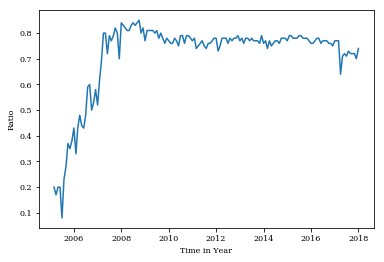

In [291]:
myFmt = DateFormatter("%Y") #define the date format
plt.rcParams['font.family'] = 'serif'
plt.rc('font', size=8)
#plt.rc('axes', titlesize=6)
plt.rc('axes', labelsize=8)
plt.figure(figsize=(6,4))
plt.plot(formatted_dependent_required_vs_total_package['date'],formatted_dependent_required_vs_total_package['value'])
plt.xlabel('Time in Year')
plt.ylabel('Ratio')
#plt.title('Proportion of dependent packages')
plt.rcParams["figure.figsize"] = [16,5] #modify figure size
ax = plt.axes()
ax.xaxis.set_major_formatter(myFmt)

folder='fig'
mkdir_p(folder)

plt.savefig('{}/proportion-of-dependent-packages.pdf'.format(folder))
plt.savefig('{}/proportion-of-dependent-packages.png'.format(folder), dpi=300)

Proportion of dependent packages (dependent package/total package) and required package (required package/total package)

In [98]:
data = pd.read_csv('raw_dependencies.csv') #read the csv file
data=data.fillna('no') #fill al NaN values with string 'no'. This is to avoid later error if doing any query. 
data['date'] = pd.to_datetime(data['date']) #convert date from type string to type timestamp. This makes it easier to query by year
data.head() #check first 5 rows
data_split = {}
#create an empty dictionary, putting splitted dataframes as key, value pair in the dictionary. dictionary should be used when trying to use changing variable names
data['new_deps'] = data.deps.map(lambda x: [i.strip() for i in x.split(",")]) 
data['deps_count'] = data.new_deps.map(lambda x: len(x) if x!=['no'] else 0) #counting required package while making sure that 'no' values are not counted as 1


In [115]:
#calculate total packages across month-year. We need to sum unique non=dependent, dependent % required package for each 
#time split. Another approach can be to calculate them from start of time till time split for each time split
start = time.time()

#calculate unique dependent & nondependent packages across month-year

data_nondependent_dependent_split = {}
data_nondependent_dependent_package=data

for year in range(2005,2019):
    for month in range(1,13):
        data_nondependent_dependent_split['data_'+str(year)+'_'+str(month)]=data_nondependent_dependent_package[(data_nondependent_dependent_package['date'].dt.year == year) & (data_nondependent_dependent_package['date'].dt.month == month)]

nondependent_dependent_package={}
        
for keys in data_nondependent_dependent_split:
    nondependent_dependent_package[keys]=data_nondependent_dependent_split[keys]['name'].unique()

#calculate unique required packages
nondependent_dependent_required_package_all={}
for year in range(2005,2019):
    for month in range(1,13):
        nondependent_dependent_required_package=nondependent_dependent_package['data_'+str(year)+'_'+str(month)].tolist()
        for i in data_nondependent_dependent_split['data_'+str(year)+'_'+str(month)]['new_deps']:   
            for j in i:
                if j not in nondependent_dependent_required_package:
                    nondependent_dependent_required_package.append(j)
        nondependent_dependent_required_package_all['data_'+str(year)+'_'+str(month)]=len(nondependent_dependent_required_package)  
        
end = time.time()
print(end - start)

460.5216598510742


In [120]:
#calculate dependent packages across month-year
start = time.time()

data_dependent_split = {}

data_dependent_package=data.loc[data['deps_count'] != 0]

for year in range(2005,2019):
    for month in range(1,13):
        data_dependent_split['data_'+str(year)+'_'+str(month)]=data_dependent_package[(data_dependent_package['date'].dt.year == year) & (data_dependent_package['date'].dt.month == month)]

dependent_package_count={}
        
for keys in data_dependent_split:
    dependent_package_count[keys]=len(data_dependent_split[keys]['name'].unique())
        
end = time.time()
print(end - start)

25.368013381958008


In [137]:
#calculate the ratio
dependent_vs_total_package={x:float("{0:.2f}".format(float(dependent_package_count[x])/nondependent_dependent_required_package_all[x])) for x in total_package_count if total_package_count[x]!=0} #making a list of the division of previous 2 dictionary while formatting it to two decimal place. Alternatively, round may be used. 

formatted_dependent_vs_total_package={}
for key, value in dependent_vs_total_package.items():
    formatted_dependent_vs_total_package[key[5:]]=value

In [138]:
#convering date colmun to datetime again for plotting respect to year
formatted_dependent_vs_total_package=pd.DataFrame.from_dict(formatted_dependent_vs_total_package, orient='index').reset_index()
formatted_dependent_vs_total_package.rename(columns={'index': 'date', 0: 'value'}, inplace=True)
formatted_dependent_vs_total_package['date'] = pd.to_datetime(formatted_dependent_vs_total_package['date'], format='%Y_%m')

In [126]:
start = time.time()

#calculate unique required packages
required_package_all={}
for year in range(2005,2019):
    for month in range(1,13):
        required_package=[]
        for i in data_dependent_split['data_'+str(year)+'_'+str(month)]['new_deps']:   
            for j in i:
                if j not in required_package:
                    required_package.append(j)
        required_package_all['data_'+str(year)+'_'+str(month)]=len(required_package)  
        
end = time.time()
print(end - start)

48.81350612640381


In [127]:
#calculate ratio

required_vs_total_package={x:float("{0:.2f}".format(float(required_package_all[x])/nondependent_dependent_required_package_all[x])) for x in total_package_count if total_package_count[x]!=0} #making a list of the division of previous 2 dictionary while formatting it to two decimal place. Alternatively, round may be used. 

formatted_required_vs_total_package={}
for key, value in required_vs_total_package.items():
    formatted_required_vs_total_package[key[5:]]=value

In [128]:
#for required
formatted_required_vs_total_package=pd.DataFrame.from_dict(formatted_required_vs_total_package, orient='index').reset_index()
formatted_required_vs_total_package.rename(columns={'index': 'date', 0: 'value'}, inplace=True)
formatted_required_vs_total_package['date'] = pd.to_datetime(formatted_required_vs_total_package['date'], format='%Y_%m')

In [ ]:
#This is not used

#print(dependent_ratio)
x=formatted_required_vs_total_package.keys() #put dictionary keys in a list
y=formatted_required_vs_total_package.values() #put dictionary values in a list
plt.plot(x,y) #make a line plot, using pyplot
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.title('Proportion of required package')
plt.rcParams["figure.figsize"] = [16,5] #modify figure size
ax = plt.axes()
xmajorlocator = LinearLocator(20)
ax.xaxis.set_major_locator(xmajorlocator)
#plt.bar(range(len(dependent_ratio)), dependent_ratio.values(), align="center")
#plt.xticks(range(len(dependent_ratio)), list(dependent_ratio.keys()))

In [300]:
#function for creatign folder
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

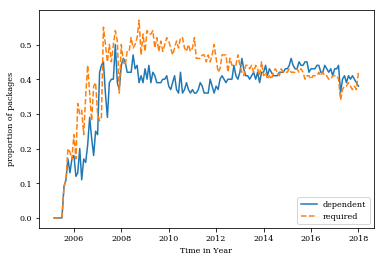

In [292]:
myFmt = DateFormatter("%Y") #define the date format
plt.rcParams['font.family'] = 'serif'
plt.rc('font', size=8)
#plt.rc('axes', titlesize=6)
plt.rc('axes', labelsize=8)
plt.figure(figsize=(6,4))
plt.plot(formatted_dependent_vs_total_package['date'],formatted_dependent_vs_total_package['value'], label='dependent')
plt.plot(formatted_required_vs_total_package['date'],formatted_required_vs_total_package['value'], linestyle='--', label='required')
plt.xlabel('Time in Year')
plt.ylabel('proportion of packages')
#plt.title('Proportion of dependent packages')
#plt.rcParams["figure.figsize"] = [16,5] #modify figure size
ax = plt.axes()
ax.xaxis.set_major_formatter(myFmt)
legend = plt.legend(loc='lower right')

folder='fig'
mkdir_p(folder)

plt.savefig('{}/proportion-of-dependent-and-required-packages.pdf'.format(folder))
plt.savefig('{}/proportion-of-dependent-and-required-packages.png'.format(folder), dpi=300)


Cumulative proportion of required package

In [296]:
data = pd.read_csv('output.csv') #read the csv file

In [297]:
reverse_dependencies_for_required_packages=data.groupby('deps').count()
#data.groupby('deps').count().sum()
X=reverse_dependencies_for_required_packages['name'].tolist()
X = np.asarray(X)
X.sort()

In [301]:
#function for creatign folder
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

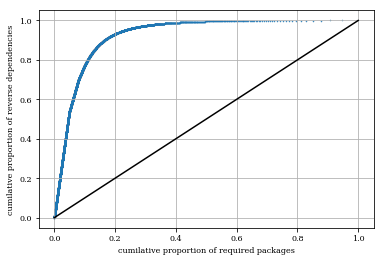

In [298]:
#Lorenz curve

X_lorenz = X.cumsum() / X.sum()

plt.rcParams['font.family'] = 'serif'
plt.rc('font', size=8)
plt.rc('axes', labelsize=8)
plt.figure(figsize=(6,4))
plt.scatter( X_lorenz, np.arange(X_lorenz.size)/(X_lorenz.size-1), marker='.', s=1)
plt.plot([0,1], [0,1], color='k')
plt.xlabel('cumilative proportion of required packages')
plt.ylabel('cumilative proportion of reverse dependencies')
plt.grid()

folder='fig'
mkdir_p(folder)

plt.savefig('{}/inverted_lorenz_curves_for_reverse_dependencies.pdf'.format(folder))
plt.savefig('{}/cumilative_proportion_of_required_packages.png'.format(folder), dpi=300)
    

Gini Index

In [255]:
data = pd.read_csv('raw_dependencies.csv') #read the csv file

data = data.dropna()
data['date'] = pd.to_datetime(data['date']) #convert date from type string to type timestamp. This makes it easier to query by year

data_new=data.drop_duplicates(subset ="name", keep = 'last', inplace = False) 
data_new=data.drop(['version','raw_dependencies'],axis=1)

data_newer = data_new.reindex(data_new.index.repeat(data_new['deps'].fillna("").str.split(',').apply(len)))
data_newer = data_newer.drop(['deps'],1)
s = data_new['deps'].str.split(',', expand=True).stack().reset_index(level=1,drop=True)
data_newer = data_newer.set_index(data_newer.groupby(data_newer.index).cumcount(), append=True)
s = s.to_frame('deps').set_index(s.groupby(s.index).cumcount(), append=True)
data_newer = data_newer.join(s, how='outer').reset_index(level=[0,1],drop=True)

data_newer_split = {}
for year in range(2005,2019):
    for month in range(1,13):
        data_newer_split['data_'+str(year)+'_'+str(month)]=data_newer[(data_newer['date'].dt.year == year) & (data_newer['date'].dt.month == month)]

for key in data_newer_split:
    data_newer_split[key]=data_newer_split[key].drop(['date'],axis=1)        

In [265]:
reverse_dependencies_for_required_packages={}
#reverse_dependencies_for_required_packages=data.groupby('deps').count()

for key in data_newer_split:
    reverse_dependencies_for_required_packages[key]=data_newer_split[key].groupby('deps').count()

In [267]:
#https://stackoverflow.com/a/39513799/10733776
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [268]:
gini_value={}

for key, value in reverse_dependencies_for_required_packages.items():
    if len(value) != 0:
        X=reverse_dependencies_for_required_packages[key]['name'].tolist()
        X = np.asarray(X)
        gini_value[key]=gini(X)

In [270]:
formatted_gini_value={}
for key, value in gini_value.items():
    formatted_gini_value[key[5:]]=value

In [273]:
formatted_gini_value=pd.DataFrame.from_dict(formatted_gini_value, orient='index').reset_index()
formatted_gini_value.rename(columns={'index': 'date', 0: 'value'}, inplace=True)
formatted_gini_value['date'] = pd.to_datetime(formatted_gini_value['date'], format='%Y_%m')

In [299]:
#function for creatign folder
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''
    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

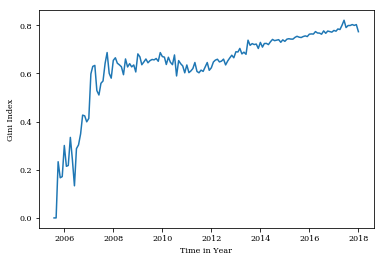

In [274]:
#print(dependent_ratio)
plt.rcParams['font.family'] = 'serif'
plt.rc('font', size=8)
plt.rc('axes', labelsize=8)
plt.figure(figsize=(6,4))
plt.plot(formatted_gini_value['date'],formatted_gini_value['value'])
plt.xlabel('Time in Year')
plt.ylabel('Gini Index')

folder='fig'
mkdir_p(folder)

plt.savefig('{}/evolution-of-the-gini-index.pdf'.format(folder))
plt.savefig('{}/evolution-of-the-gini-index.png'.format(folder), dpi=300)

Reusability Index

In [276]:
data = pd.read_csv('raw_dependencies.csv') #read the csv file
data = data.dropna()
data['date'] = pd.to_datetime(data['date']) #convert date from type string to type timestamp. This makes it easier to query by year

data_new=data.drop(['version','raw_dependencies'],axis=1)

data_newer = data_new.reindex(data_new.index.repeat(data_new['deps'].fillna("").str.split(',').apply(len)))
data_newer = data_newer.drop(['deps'],1)
s = data_new['deps'].str.split(',', expand=True).stack().reset_index(level=1,drop=True)
data_newer = data_newer.set_index(data_newer.groupby(data_newer.index).cumcount(), append=True)
s = s.to_frame('deps').set_index(s.groupby(s.index).cumcount(), append=True)
data_newer = data_newer.join(s, how='outer').reset_index(level=[0,1],drop=True)


In [277]:
data_reusability={}
for year in range(2005,2019):
    data_reusability['data_'+str(year)]=data_newer[(data_newer['date'].dt.year == year)]
    data_reusability['data_'+str(year)]=data_reusability['data_'+str(year)].drop_duplicates(subset ="name", keep = 'last', inplace = False) 
    data_reusability['data_'+str(year)]=data_reusability['data_'+str(year)].drop(['date'],axis=1)


In [280]:
reverse_dependencies_for_required_packages={}
for keys in data_reusability:
    reverse_dependencies_for_required_packages[keys]=data_reusability[keys].groupby('deps').count().sort_values(by='name', ascending=False)

In [ ]:
for keys, values in reverse_dependencies_for_required_packages.items():
    reverse_dependencies_for_required_packages[keys]=values.reset_index()

In [281]:
resusability={}
count=0
for keys in reverse_dependencies_for_required_packages:
    for index, row in reverse_dependencies_for_required_packages[keys].iterrows():
        if count<row['name']:
            count=count+1
        else:
            resusability[keys[5:]]=count

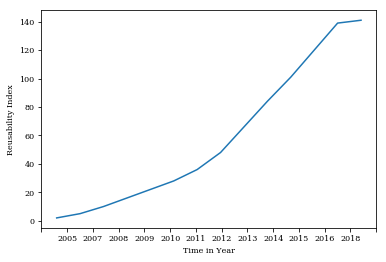

In [290]:
#print(dependent_ratio)
plt.rcParams['font.family'] = 'serif'
plt.rc('font', size=8)
plt.rc('axes', labelsize=8)
plt.figure(figsize=(6,4))
x=resusability.keys() #put dictionary keys in a list
y=resusability.values() #put dictionary values in a list
plt.plot(x,y) #make a line plot, using pyplot
plt.xlabel('Time in Year')
plt.ylabel('Reusability Index')
#plt.title('Reusability Index')
ax = plt.axes()
xmajorlocator = LinearLocator(14)
ax.xaxis.set_major_locator(xmajorlocator)

folder='fig'
mkdir_p(folder)

plt.savefig('{}/evolution-of-reusability-index.pdf'.format(folder))
plt.savefig('{}/evolution-of-reusability-index.png'.format(folder), dpi=300)